In [68]:
#Libraries 
import praw
import pandas as pd
from datetime import datetime as dt
import time, calendar
import psycopg2
import time
import pymongo
starttime=time.time()
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from scipy.stats import linregress




In [10]:
# Write file to dataFrame
filepath = "df_reddit.csv"

dataframereddit = pd.read_csv(filepath, sep = '\t', encoding ='utf-8', parse_dates=['Created'])
dataframereddit


,Unnamed: 0,ID,Title,Body,Score,URL,Comments,Created
0,0,ejl023,Perfect timing,NaN,17413,https://v.redd.it/ayzsxc2tfm841,315,2020-01-04 04:14:06
1,1,ejk48x,TIL Research shows that children as young as 4...,NaN,23802,https://news.yale.edu/2018/07/23/even-4-year-o...,1116,2020-01-04 03:14:08
2,2,ejk3qx,In The Lego Movie (2014) Benny the spaceman ha...,NaN,18413,https://i.redd.it/1yf0ofvx4m841.jpg,264,2020-01-04 03:13:11
3,3,ejjmjr,Recommendations!,NaN,24502,https://i.redd.it/j6e4ge34zl841.jpg,101,2020-01-04 02:40:32
4,4,ejkcib,New Years photobomb!,NaN,11507,https://i.redd.it/1dashplv7m841.jpg,173,2020-01-04 03:29:40
...,...,...,...,...,...,...,...,...
6268834,7172467,el49up,"umm, oopsie!",NaN,344,https://i.redd.it/rldx31cqi9941.jpg,11,2020-01-07 09:51:27
6268835,7172468,elbkks,So do you want the green meth or the blue meth?,NaN,43,https://i.redd.it/2wuua1bfzc941.jpg,4,2020-01-07 21:30:22
6268836,7172469,elb5dc,Ah yes happened yesterday,NaN,45,https://i.redd.it/i82z1sx7sc941.jpg,1,2020-01-07 20:49:58
6268837,7172471,elbngo,Me Trying to sleep,NaN,40,https://i.redd.it/lflndbnq0d941.png,1,2020-01-07 21:37:44


In [8]:
# Cleaning work: take out currently unneeded or messy columns 'Body', 'URL', 'Unnamed: 0', 'Title' 
# and then drop duplicates and any column missing values
work = dataframereddit.copy()
work.drop(['Body', 'URL', 'Unnamed: 0', 'Title'], axis=1, inplace = True)
work.dropna(axis=0, how='any', thresh=None, subset=['Score', 'Comments', 'Created'] , inplace=True)
work.drop_duplicates(subset = ['Created'], inplace = True)
work


,ID,Score,Comments,Created
0,ejl023,17413,315,2020-01-04 04:14:06
1,ejk48x,23802,1116,2020-01-04 03:14:08
2,ejk3qx,18413,264,2020-01-04 03:13:11
3,ejjmjr,24502,101,2020-01-04 02:40:32
4,ejkcib,11507,173,2020-01-04 03:29:40
...,...,...,...,...
6268830,elbovy,43,2,2020-01-07 21:41:11
6268832,elbl79,43,1,2020-01-07 21:32:03
6268833,elbo8n,40,3,2020-01-07 21:39:39
6268835,elbkks,43,4,2020-01-07 21:30:22


In [9]:
# Important info: this contains some basic info to inform analyses
work.describe()

# work.mean()
# Score avg = 699.77
# Comments avg = 27.23
# Total hours = 73:25:09
# work.Score.max() = 107874
# work.Score.min() = 35
# comments min = 0
# comments max = 30699
# created max= 2020-01-06 21:41:52
# Created min = 2020-01-03 07:04:51
# work.Created.max()-work.Created.min() =  Timedelta('4 days 14:37:01')
# After checking for data errors, i have removed things after 2020-01-06 8:30:00. I had 
# somehow scraped posts from those dates despite stopping to scrape at that max time
# time delta = 2 days, 22 hour, 55 minutes and 9 seconds

,Score,Comments
count,69395.000000,69395.000000
mean,699.769321,27.236804
std,3485.502279,224.949867
min,35.000000,0.000000
25%,65.000000,3.000000
50%,91.000000,6.000000
75%,247.000000,16.000000
max,107874.000000,30699.000000


/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


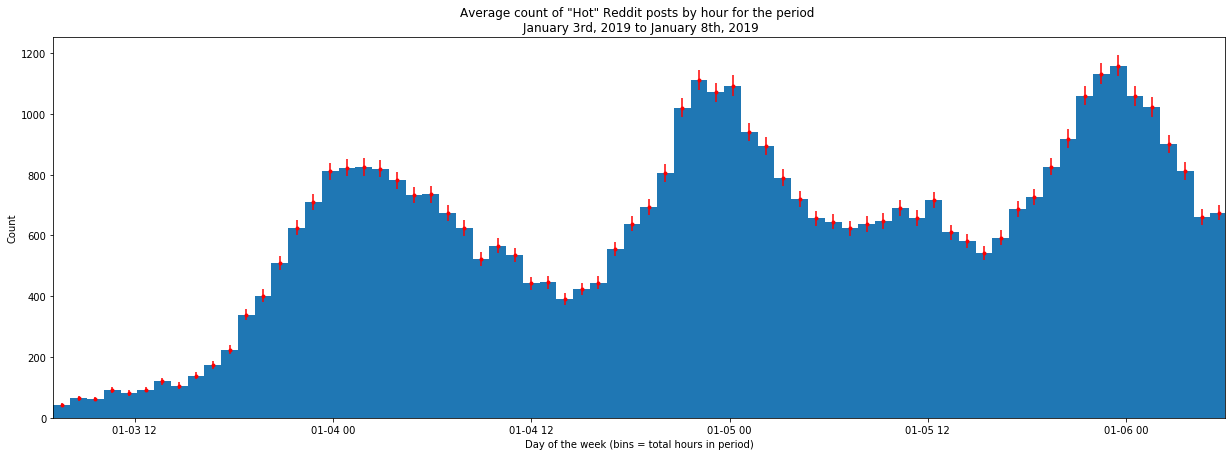

In [69]:
# Here we show a histogram by day of the counts of posts binned into hours. 
work.sort_values(by=['Score'], ascending = False, inplace = True)
data = work.Created
data1 = work.copy()
data1.set_index('Score', inplace = True)
data1.drop(['ID', 'Comments'], axis = 1, inplace = True)
# plot
fig, ax = plt.subplots(figsize=([21,7]))

# # calculate bin centers
entries1, edges1, _ = plt.hist(data1.Created, bins=109)
bin_centers = 0.5 * (edges1[:-1] + edges1[1:])

# # draw errorbars, use the sqrt error. 
plt.errorbar(bin_centers, entries1, yerr=np.sqrt(entries1), fmt='r.')

# labels
ax.set_xlabel('Day of the week (bins = total hours in period)')
ax.set_ylabel('Count')

ax.set_title('Average count of "Hot" Reddit posts by hour for the period \n January 3rd, 2019 to January 8th, 2019')
# ax.set_xticks(ticks=list(range(0,121))) 
# data after this period was wonky. won't be included in final analyses
plt.xlim('2020-01-03 07:04:51', '2020-01-06 6:00:00')
plt.show()



In [70]:
# removed posts with score < than rounded average value for analyses

scorework = work.copy()

scorework = scorework[scorework['Score'] > 699]
#convert created values to datetime
scorework['Created'] = pd.to_datetime(work['Created'], errors='coerce')

scorework.drop(['ID', 'Comments', 'Created'], axis=1, inplace = True)


In [71]:
# removed posts with # of comments < than rounded average value for analyses
commentwork = work.copy()

commentwork = commentwork[commentwork['Comments'] > 27]
#convert created values to datetime
commentwork['Created'] = pd.to_datetime(work['Created'], errors='coerce')


commentwork.drop(['ID', 'Score', 'Created'], axis=1, inplace = True)

In [72]:
# Analysis chi square work
# alt Hypothesis: the values are not independetnt on one another
# null h: the values are independently distributed


Scorearray = scorework.groupby(work["Created"].dt.hour).count().Score.values
Commentarray = commentwork.groupby(work["Created"].dt.hour).count().Comments.values

# degrees of freedom = (#rows - 1)(#columns -1)
stats.chi2_contingency([Scorearray, Commentarray])
# Scorearray.sum()
# Commentarray.sum()+Scorearray.sum()

(291.3001973491556,
 2.6088667007480966e-48,
 23,
 array([[555.71474721, 464.70004846, 411.75399774, 329.05314166,
         281.35793894, 248.54013891, 300.17347763, 290.98449362,
         255.97884025, 247.22742691, 258.16669359, 278.29494427,
         259.91697626, 220.97318688, 196.90680019, 178.96640284,
         224.91132289, 233.22516556, 283.54579228, 315.92602164,
         422.25569375, 575.40542723, 638.4156033 , 654.60571798],
        [714.28525279, 597.29995154, 529.24600226, 422.94685834,
         361.64206106, 319.45986109, 385.82652237, 374.01550638,
         329.02115975, 317.77257309, 331.83330641, 357.70505573,
         334.08302374, 284.02681312, 253.09319981, 230.03359716,
         289.08867711, 299.77483444, 364.45420772, 406.07397836,
         542.74430625, 739.59457277, 820.5843967 , 841.39428202]]))

In [46]:
# Next step: do an analysis of the data to determine if there is a significant difference in 
# average score values in the beginning of the day, and the end of the day. then do the same for comments



In [74]:
# removed posts with score < than rounded average value
# TAGGED FOR REMOVAL, left here so i didnt have to scroll up
scorework = work.copy()

scorework = scorework[scorework['Score'] > 699]
# x = work['Score']
scorework['Created'] = pd.to_datetime(work['Created'], errors='coerce')

scorework.drop(['ID', 'Comments', 'Created'], axis=1, inplace = True)
len(scorework)


8127

In [73]:
# removed posts with # of comments < than rounded average value
# TAGGED FOR REMOVAL
commentwork = work.copy()

commentwork = commentwork[commentwork['Comments'] > 27]
# x = work['Score']
commentwork['Created'] = pd.to_datetime(work['Created'], errors='coerce')


commentwork.drop(['ID', 'Score', 'Created'], axis=1, inplace = True)
len(commentwork)


10446

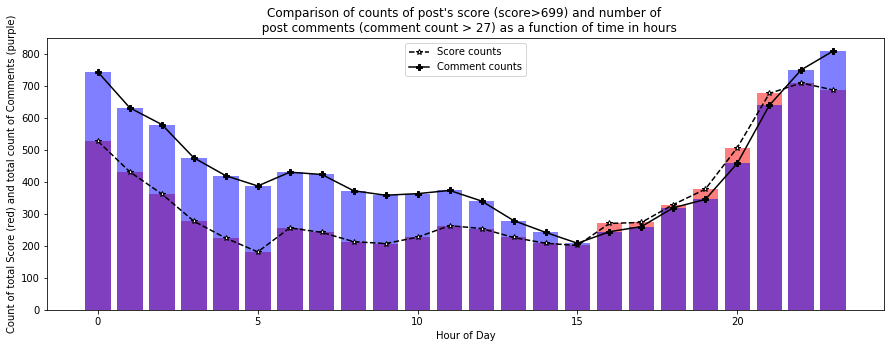

In [75]:
# create dataframe from score and comment counts by hour, make an hour column to make x axis
test_df = commentwork.groupby(work["Created"].dt.hour).count()
test_df['score']= scorework.groupby(work["Created"].dt.hour).count()
test_df['Created'] = list(range(0,24))

#create plots

fig, ax = plt.subplots(figsize=([15,5]))
# plot lines between heights
plt.plot(test_df.Created, test_df.score, color = 'black', alpha = 1, label = 'Score counts', linestyle='dashed', marker = '*', markerfacecolor='White')

plt.plot(test_df.Created, test_df.Comments,color = 'black',alpha = 1, label = 'Comment counts', marker = 'P', markerfacecolor = 'Black')

# plot bar charts
rects1 = ax.bar(test_df.Created, test_df.score, color='r', alpha = .5)

rects2 = ax.bar(test_df.Created, test_df.Comments, color = 'b', alpha= .5)

# set labels
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Count of total Score (red) and total count of Comments (purple)')
ax.legend()
ax.set_title("Comparison of counts of post's score (score>699) and number of \n  post comments (comment count > 27) as a function of time in hours")
plt.show()

In [50]:
# multinomial distribution chi square analysis
# null hypothesis: the plot of highly commented posts per hour and the plot of highly scored posts per hour are independently distributed
# alternative hypothesis: the two plots are dependent, and therefore affected by the same factors. 



# degrees of freedom = (#rows - 1)(#columns -1)
stats.chi2_contingency([Scorearray, Commentarray])
# NOTE: The null hypothesis for a chi-square independence test is that two categorical 
# variables are independent in some population

# based on these findings (x2(23) = 83.676, p<.05), we can accept our alternate hypothesis that 
# the two plots are come from the distributions of two dependent variables. 


(291.3001973491556,
 2.6088667007480966e-48,
 23,
 array([[555.71474721, 464.70004846, 411.75399774, 329.05314166,
         281.35793894, 248.54013891, 300.17347763, 290.98449362,
         255.97884025, 247.22742691, 258.16669359, 278.29494427,
         259.91697626, 220.97318688, 196.90680019, 178.96640284,
         224.91132289, 233.22516556, 283.54579228, 315.92602164,
         422.25569375, 575.40542723, 638.4156033 , 654.60571798],
        [714.28525279, 597.29995154, 529.24600226, 422.94685834,
         361.64206106, 319.45986109, 385.82652237, 374.01550638,
         329.02115975, 317.77257309, 331.83330641, 357.70505573,
         334.08302374, 284.02681312, 253.09319981, 230.03359716,
         289.08867711, 299.77483444, 364.45420772, 406.07397836,
         542.74430625, 739.59457277, 820.5843967 , 841.39428202]]))

In [76]:
# find the averages for each category for posts per hour made before noon and afternoon, 

# MORNING VS AFTERNOON: here i made morning and afternoon, arrays containing 
# the count of posts above the threshold by hour seperated by noon. see next cell for results
# use commentwork and scorework because they were already controlled for below average posts

# COMMENTS SECTION
commentcounts = commentwork.groupby(work["Created"].dt.hour).count()
commentcounts['Created'] = list(range(0,24))
morning_com = commentcounts[commentcounts['Created']<12]
afternoon_com = commentcounts[commentcounts['Created']>11]

# Scores
scorecounts = scorework.groupby(work["Created"].dt.hour).count()
scorecounts['Created'] = list(range(0,24))
morning_score = scorecounts[scorecounts['Created']<12]
afternoon_score = scorecounts[scorecounts['Created']>11]


# Analysis of work hours versus recreational hours
# reset scorecounts
scorecounts = scorework.groupby(work["Created"].dt.hour).count()
scorecounts['Created'] = list(range(0,24))
scorecounts['hour'] = scorecounts['Created']
scorecounts.set_index('hour', inplace = True)
morning_com.Comments

Created
0     743
1     631
2     579
3     475
4     419
5     387
6     430
7     423
8     372
9     358
10    363
11    373
Name: Comments, dtype: int64

In [82]:
# Question: is there a significant difference in the number of posts above the comment and score 
# value thresholds in the former and latter halves of the day?

# alternate hypothesis: there will be a difference in the values for comments and scores between the two samples
# null hypothesis: the averages are distributed in the same way and are effectively the same. 
stats.ttest_ind(morning_com.Comments.values, afternoon_com.Comments.values)
# Ttest_indResult(statistic=0.7830754888224885, pvalue=0.4419315022610524

# These results indicate that we do not have sufficient findings to reject our null hypothesis. 
# this indicates that there is no significant difference in the 

stats.ttest_ind(morning_score.Score.values, afternoon_score.Score.values)
# the scores are even closer to being the same distribution than the comment values
# Ttest_indResult(statistic=1.6995380685604065, pvalue=0.10331556790097678)


Ttest_indResult(statistic=-1.6876909745958304, pvalue=0.10559878652817885)

In [84]:
# is there a significant difference in the number of posts above the comment and score 
# value thresholds in typical working hours and the rest of the day

# SCORE
# work to seperate the data for work hours score
work_hours_sco = scorecounts[scorecounts['Created']>=9]
work_hours_sco = work_hours_sco[work_hours_sco['Created']<=18]

# how to put to remove unwanted times rather than add new ones to a new dataframe
private_hours_sco = scorecounts.copy()
for i in range(9,19):
    private_hours_sco = private_hours_sco[private_hours_sco.Created != i]
 
# TEST SCORE
stats.ttest_ind(private_hours_sco.Score.values, work_hours_sco.Score.values)
# tTtest_indResult(statistic=2.620484073344668, pvalue=0.015619460530590084)
# There is a significant effect of the common work hours of the day on the score value of posts.
# The mean score during work hours is significantly different than the mean score during non work hours


# COMMENTS

# work to seperate the data for work hours score
work_hours_com = commentcounts[commentcounts['Created']>=9]
work_hours_com = work_hours_com[work_hours_com['Created']<=18]


# how to put to remove unwanted times rather than add new ones to a new dataframe
private_hours_com = commentcounts.copy()
for i in range(9,19):
    private_hours_com = private_hours_com[private_hours_com.Created != i]

# TEST COMMENTS
stats.ttest_ind(private_hours_com.Comments.values, work_hours_com.Comments.values)
# Ttest_indResult(statistic=4.4907916195410325, pvalue=0.0001819168658468377)
# There is a significant effect of the common work hours of the day on the average score value of posts.
# The mean score of posts during work hours is significantly different than the mean score during non work hours.




Ttest_indResult(statistic=4.4907916195410325, pvalue=0.0001819168658468377)

In [86]:
# brief descriptions to inform analysis
private_hours_com.Comments.mean()
# print(work_hours_com.describe())
# print(private_hours_sco.describe())
# print(work_hours_sco.describe())

532.8571428571429


[Text(0, 0, 'Private Hours'), Text(0, 0, 'Work Hours')]

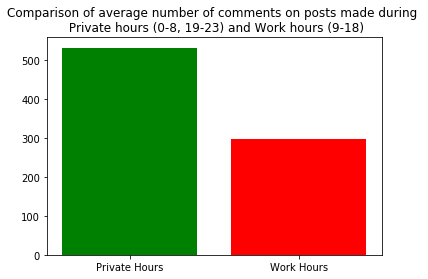

In [124]:
# NEXT STEPS
# BARCHARTS FOR TTESTS work private
fig, ax = plt.subplots()
barheights = [private_hours_com.Comments.mean(),work_hours_com.Comments.mean()]
barlabels = ['Private Hours', 'Work Hours']
graphy= ax.bar(range(len(barheights)), barheights, color=('g', 'r'))
ax.set_title('Comparison of average number of comments on posts made during \n Private hours (0-8, 19-23) and Work hours (9-18)') 
ax.set_xticks(range(len(barheights)))
ax.set_xticklabels(barlabels)




[Text(0, 0, 'Private Hours'), Text(0, 0, 'Work Hours')]

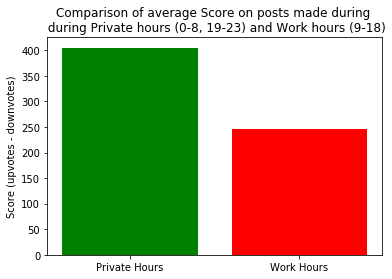

In [121]:
# NEXT STEPS
# BARCHARTS FOR TTESTS score work private
fig, ax = plt.subplots()
barheights = [private_hours_sco.Score.mean(),work_hours_sco.Score.mean()]
barlabels = ['Private Hours', 'Work Hours']
grapho = ax.bar(range(len(barheights)), barheights, color=('g', 'r'))
ax.set_title('Comparison of average Score on posts made during \n during Private hours (0-8, 19-23) and Work hours (9-18)') 
ax.set_xticks(range(len(barheights)))
ax.set_ylabel('Score (upvotes - downvotes)')
ax.set_xticklabels(barlabels)


[Text(0, 0, 'Morning (hours 0-11)'), Text(0, 0, 'Afternoon (hours 12-23)')]

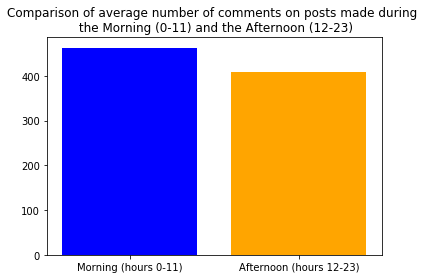

In [119]:
# afternoon morning comments
fig, ax = plt.subplots()
barheights = [morning_com.Comments.mean(),afternoon_com.Comments.mean()]
barlabels = ['Morning (hours 0-11)', 'Afternoon (hours 12-23)']
graph=ax.bar(range(len(barheights)), barheights, color=('b', 'orange'))
ax.set_title('Comparison of average number of comments on posts made during \n the Morning (0-11) and the Afternoon (12-23)') 
ax.set_xticks(range(len(barheights)))
ax.set_xticklabels(barlabels)




Text(0, 0.5, 'Score (upvotes - downvotes)')

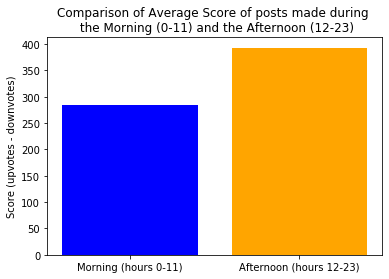

In [120]:
# afternoon morning score
fig, ax = plt.subplots()
barheights = [morning_score.Score.mean(),afternoon_score.Score.mean()]
barlabels = ['Morning (hours 0-11)', 'Afternoon (hours 12-23)']
graph=ax.bar(range(len(barheights)), barheights, color=('b', 'orange'))
ax.set_title('Comparison of Average Score of posts made during \n the Morning (0-11) and the Afternoon (12-23)') 
ax.set_xticks(range(len(barheights)))
ax.set_xticklabels(barlabels)
ax.set_ylabel('Score (upvotes - downvotes)')

